In [1]:
pwd

'/home/sandeep/GoogleDrive/GTech/CS7643_DeepLearning/Project/building_footprints_cs7643'

In [2]:
import fastai
from fastai.vision.all import *
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

In [3]:
fastai.__version__

'2.4.1'

In [4]:
path = Path('/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/image_data/data_building_footprint/training_512x512')
# [print(p.name) for p in path.ls()];

In [5]:
codes = np.array(['background','building'])

In [6]:
fnames = get_image_files(path/"images-512")

In [7]:
# #Convert all the mask of (0 and 255) to (0 and 1)
# path_mask_new = '/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/image_data/data_building_footprint/training_512x512/masks-512-coded'
# for lp in (path/"masks-512").ls():
#     l1 = cv2.imread(str(lp))
#     c1 = l1[:,:,0]
#     c11 = np.where(c1==255,1,0)
#     cv2.imwrite(path_mask_new+'/'+lp.name,c11)

In [8]:
def label_func(fn):
    ''' returns the path object for label file for passed image file path object '''
    return path/"masks-512-coded"/f"{fn.stem}{fn.suffix}"

In [9]:
# class SegLabelListCustom(SegmentationLabelList):
#     def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
# class SegItemListCustom(SegmentationItemList):
#     _label_cls = SegLabelListCustom

In [10]:
aug_tfms = aug_transforms( do_flip=True, flip_vert=True, max_zoom=2,max_lighting=0.3,max_warp=0.1)

In [11]:
dls = SegmentationDataLoaders.from_label_func(
       path, bs=16, fnames = fnames, 
       label_func = label_func, codes = codes, 
       item_tfms=[Resize(224)], batch_tfms=aug_tfms
    )

/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can

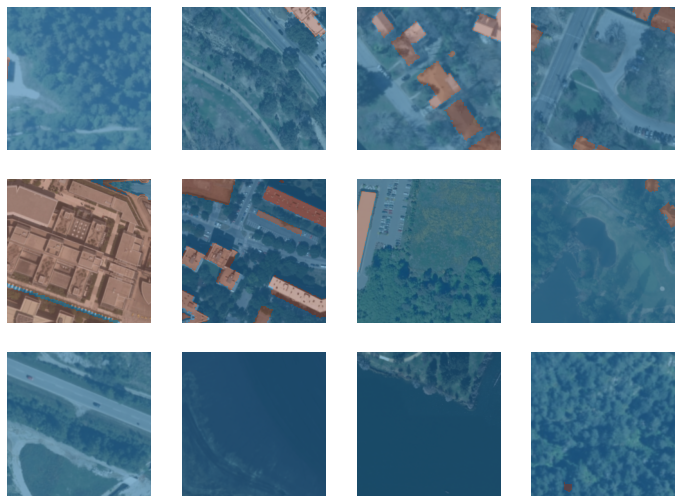

In [12]:
dls.show_batch(max_n=12)

In [13]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        print('FocalLoss : ', 'inputs.shape : ', inputs.shape, '\t', 'targets.shape : ',targets.shape)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss
        
class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        print('DiceLoss : ', 'input.shape : ',input.shape, '\t',target.shape )
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
        print('MultiChComboLoss : ' , 'output.shape : ', output.shape, '\t', 'target.shape : ',target.shape)
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
                ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,c,None])
            loss+=ch_wt*(ch_loss)
        return loss/sum(self.ch_wts)

In [14]:
FocalLossFlat

fastai.losses.FocalLossFlat

In [15]:
CrossEntropyLossFlat

fastai.losses.CrossEntropyLossFlat

In [16]:
from fastai.vision.all import *

__all__ = ['DiceLoss', 'CombinedLoss']

def _one_hot(x, classes, axis=1):
    "Target mask to one hot"
    return torch.stack([torch.where(x==c, 1,0) for c in range(classes)], axis=axis)

class DiceLoss:
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1, smooth=1): 
        store_attr()
    def __call__(self, pred, targ):
        targ = _one_hot(targ, pred.shape[1])
        pred, targ = flatten_check(self.activation(pred), targ)
        inter = (pred*targ).sum()
        union = (pred+targ).sum()
        return 1 - (2. * inter + self.smooth)/(union + self.smooth)
    
    def activation(self, x): return F.softmax(x, dim=self.axis)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    

class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1, alpha=1):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)


In [17]:
# dls.loss_func = FocalLossFlat()
# dls.train_ds.loss_func = FocalLossFlat()
# dls.valid_ds.loss_func = FocalLossFlat()
# dls.train.loss_func = FocalLossFlat()
# dls.valid.loss_func = FocalLossFlat()


In [18]:
learn = unet_learner(dls, resnet34, normalize=True, loss_func=CombinedLoss(), metrics=DiceMulti())

/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [20]:
# out = learn.predict(Path('/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/image_data/data_building_footprint/training_512x512/masks-512/austin1_0.png'))

In [21]:
# [type(o) for o in out],[o.shape for o in out]
# [type(o) for o in out],[o.shape for o in out]
# #load the model if saved already
# learn.load('model_fastai_base_segmentation')

In [21]:
learn.fine_tune(20)

epoch,train_loss,valid_loss,dice_multi,time
0,0.177530,0.166013,0.869865,05:08


epoch,train_loss,valid_loss,dice_multi,time
0,0.154590,0.146103,0.894190,05:11
1,0.160059,0.144362,0.897606,05:14
2,0.153573,0.143689,0.897920,05:14
3,0.144622,0.140722,0.899770,05:15
4,0.152380,0.143657,0.901237,05:18
5,0.147454,0.140612,0.900532,05:21
6,0.142518,0.141276,0.901187,05:32
7,0.144282,0.139694,0.903344,05:22
8,0.143837,0.134789,0.906690,05:30
9,0.139803,0.129569,0.909307,05:32


In [ ]:
learn.save('model_fastai_focal_dice_segmentation_1_20ep')

In [65]:
#20 more epochs
learn.fine_tune(20)

epoch,train_loss,valid_loss,dice_multi,time
0,0.121640,0.130882,0.910319,04:50


epoch,train_loss,valid_loss,dice_multi,time
0,0.116085,0.121811,0.914981,05:14
1,0.120225,0.121243,0.914780,05:27
2,0.118031,0.123198,0.912009,05:31
3,0.128207,0.124639,0.913988,05:38
4,0.124612,0.127688,0.910428,05:40
5,0.129840,0.130327,0.912507,05:45
6,0.121466,0.124840,0.911236,06:01
7,0.129593,0.129514,0.907470,05:59
8,0.124193,0.124592,0.910633,05:51
9,0.124650,0.121679,0.914950,05:57


In [68]:
learn.save('model_fastai_focal_dice_segmentation_2_40ep')

Path('/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/image_data/data_building_footprint/training_512x512/models/model_fastai_focal_dice_segmentation_2_40ep.pth')

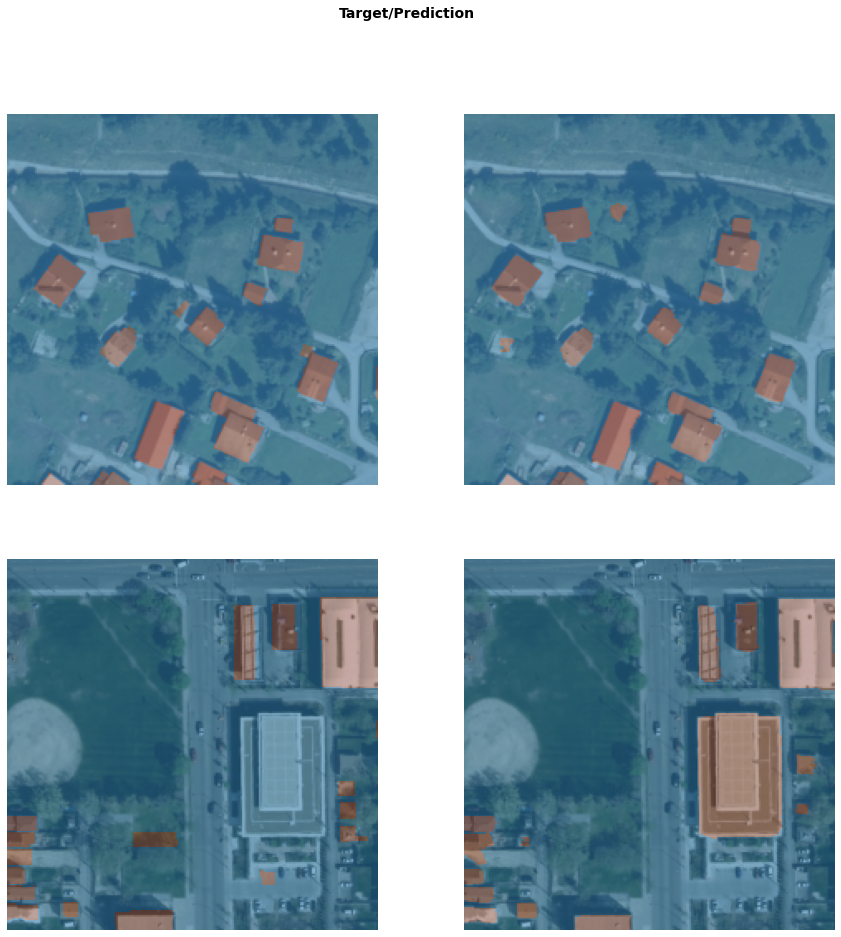

In [66]:
learn.show_results(max_n=2, figsize=(15,15))

Path('/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/image_data/data_building_footprint/training_512x512/models/model_fastai_focal_dice_segmentation_1_20ep.pth')

In [64]:
# learn.load('model_fastai_focal_dice_segmentation_1')
learn.load('model_fastai_focal_dice_segmentation_2_40ep')

In [ ]:
res = learn.predict(cv2.imread('/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/images_home/tiles_xy/tile_sat_z20_84405_203416.png'))

In [ ]:
res= learn.predict(Path('/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/images_home/tiles_xy_1/tile_sat_z20_84526_203498.png'))
plt.imshow(res[2][1]>0.75)

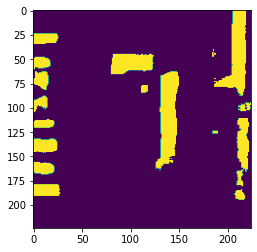

In [78]:
res= learn.predict(Path('/home/sandeep/Desktop/CS7643_DeepLearning/Project/building_footprints_cs7643/demo.png'))
plt.imshow(res[2][1]>0.75)

In [61]:
res= learn.predict(Path('/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/images_home/tiles_xy_1/tile_sat_z20_84526_203498.png'))

/home/sandeep/GoogleDrive/beans-home/mount_shared_partition/conda_envs/solaris/lib/python3.7/site-packages/fastai/metrics.py:366: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


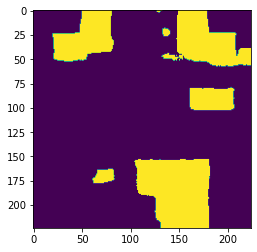

In [62]:
plt.imshow(res[0])

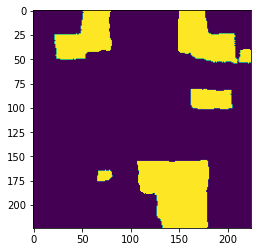

In [55]:
plt.imshow(res[2][1]>0.75)

In [35]:
torch.max(res[2][1]),torch.min(res[2][1])

(TensorBase(0.9936), TensorBase(2.5281e-06))

## Collective Inference

In [2]:
import fastai
from fastai.vision.all import *
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

In [3]:
demo_im = Image.open('/home/sandeep/Desktop/CS7643_DeepLearning/Project/building_footprints_cs7643/demo.png')
demo_im = Image.open('./demo.png')
demo_im_out = './demo_out.png'
to_tensor = transforms.ToTensor()
to_image = transforms.ToPILImage()
demo_im = to_tensor(demo_im)
#strip transparency layer
demo_im = demo_im[0:3, :, :]


In [ ]:
def run_inference_model1(img_pil):
    
    


In [4]:
type(demo_im)

PIL.PngImagePlugin.PngImageFile